# Task 1: Tangency Portfolio

## 1(a) Calculating Allocations and Volatility for Different $r_f$

### Implementation Process

The code determines optimal asset allocations and portfolio volatility for three different risk-free rates ($r_f$). The process involves these steps:

#### Step 1: Input Data Definition
- Defines expected returns ($\mu$)
- Defines volatilities ($\sigma$) 
- Defines correlation matrix ($R_{corr}$) for four assets
- Establishes a list of three distinct risk-free rates

#### Step 2: Mathematical Model for Covariance
Computes the covariance matrix ($\Sigma$) using:
$$\Sigma = \text{diag}(\sigma) \times R_{corr} \times \text{diag}(\sigma)$$

This matrix quantifies the relationships between asset returns.

#### Step 3: Iteration and Calculation
For each risk-free rate:
- Uses analytical model to find optimal portfolio weights ($w_T^*$):
$$w_T^* = \frac{\Sigma^{-1}(\mu - r_f 1)}{1' \Sigma^{-1} (\mu - r_f 1)}$$

This represents the tangency portfolio that maximizes the Sharpe ratio.

#### Step 4: Portfolio Volatility
Computes total portfolio volatility ($\sigma_\Pi$) using:
$$\sigma_\Pi = \sqrt{(w_T^*)' \Sigma w_T^*}$$

#### Step 5: Output
Produces a table displaying:
- Optimal weights
- Portfolio volatility 
For each risk-free rate, showing how the portfolio adjusts to changing risk-free environment.

In [27]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.optimize import minimize

# Asset data
assets = ['A', 'B', 'C', 'D']
mu = np.array([0.02, 0.07, 0.15, 0.20])  # Expected returns
sigma = np.array([0.05, 0.12, 0.17, 0.25])  # Volatilities
R_corr = np.array([[1, 0.3, 0.3, 0.3],
                   [0.3, 1, 0.6, 0.6],
                   [0.3, 0.6, 1, 0.6],
                   [0.3, 0.6, 0.6, 1]])  # Correlation matrix
n = len(mu)

# Risk-free rates in decimal (converted from bps)
r_f_list = [0.0025, 0.0125, 0.02]  # 25bps, 125bps, 200bps

def get_cov_matrix(sigma, R_corr):
    """
    Calculate covariance matrix from volatility and correlation matrix
    Σ = diag(σ) × R × diag(σ)
    """
    diag_sigma = np.diag(sigma)
    return diag_sigma @ R_corr @ diag_sigma

# Calculate covariance matrix
cov_matrix = get_cov_matrix(sigma, R_corr)
pd.DataFrame(cov_matrix, index=assets, columns=assets).round(4)


def tangency_portfolio_weights(mu, sigma, R_corr, r_f):
    """
    Calculate tangency portfolio weights using the analytical solution
    """
    # Calculate covariance matrix
    Sigma = get_cov_matrix(sigma, R_corr)
    
    # Create (μ - r_f * 1) vector
    ones = np.ones_like(mu)
    mu_minus_rf = mu - r_f * ones
    
    # Calculate Σ⁻¹(μ - r_f 1)
    inv_Sigma = np.linalg.inv(Sigma)
    numerator = inv_Sigma @ mu_minus_rf
    
    # Calculate denominator 1'Σ⁻¹(μ - r_f 1)
    denominator = ones.T @ inv_Sigma @ mu_minus_rf
    
    # Return tangency portfolio weights
    return numerator / denominator

def portfolio_volatility(w, Sigma):
    """Calculate portfolio volatility"""
    return np.sqrt(w.T @ Sigma @ w)

def portfolio_return(w, mu):
    """Calculate portfolio expected return"""
    return w.T @ mu

In [28]:
# Store results
results = []
Sigma = get_cov_matrix(sigma, R_corr)

for r_f in r_f_list:
    w_tangency = tangency_portfolio_weights(mu, sigma, R_corr, r_f)
    vol = portfolio_volatility(w_tangency, Sigma)
    ret = portfolio_return(w_tangency, mu)
    
    # Store results with risk-free rate in bps for readability
    results.append({
        'r_f (bps)': r_f * 10000,
        'w_A': w_tangency[0],
        'w_B': w_tangency[1],
        'w_C': w_tangency[2],
        'w_D': w_tangency[3],
        'portfolio_volatility': vol,
    })

# Display results as DataFrame
df_tangency = pd.DataFrame(results)
df_tangency.round(4)

,r_f (bps),w_A,w_B,w_C,w_D,portfolio_volatility
0,25.0,0.1874,-0.1665,0.6632,0.3159,0.1627
1,125.0,-1.9288,-0.9466,2.5384,1.3370,0.5925
2,200.0,3.5496,1.0730,-2.3161,-1.3065,0.5383


# 1(b) Plotting the Efficient Frontier

## Implementation Process

The code visualizes the efficient frontier to contextualize the optimal portfolios. The process involves:

### Step 1: Mathematical Models for Plotting
- Generates a series of portfolios by systematically varying asset weights
- Uses mathematical models for:
  - Portfolio return: $\mu_p = w'\mu$
  - Portfolio volatility: $\sigma_p = \sqrt{w'\Sigma w}$
- Maps out the curve of the efficient frontier

### Step 2: Plotting the Tangency Portfolios
- Plots the three tangency portfolios from part (a) as distinct points on the curve

### Step 3: Plotting the CML
- Can plot the Capital Market Line (CML) for each $r_f$
- The CML is a straight line originating from the risk-free rate and passing through its corresponding tangency portfolio

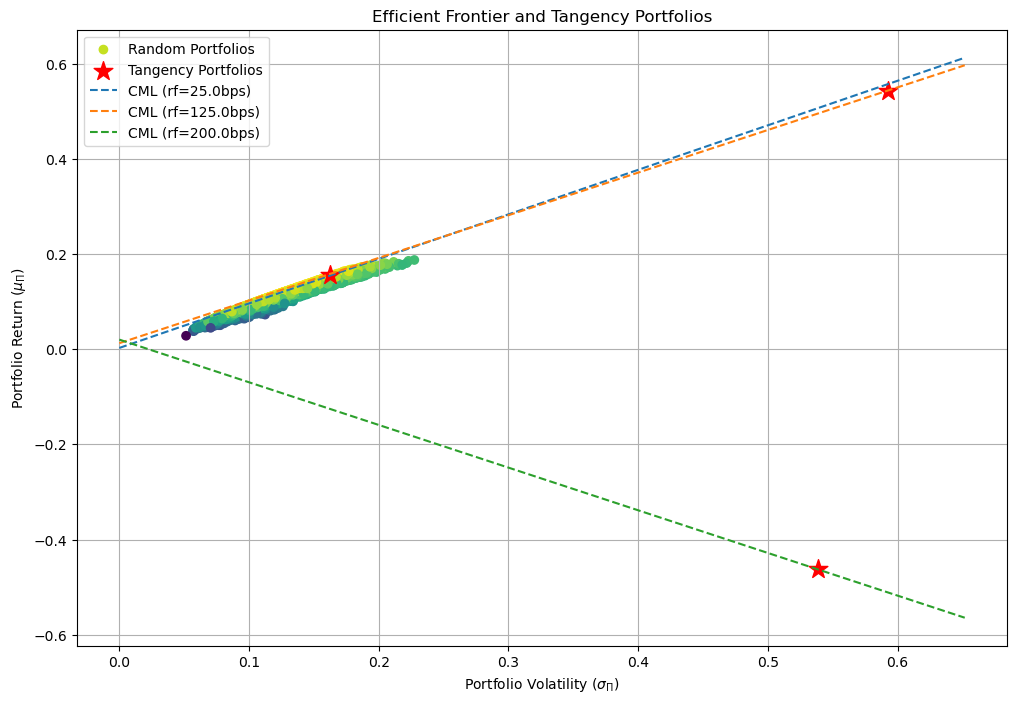

In [29]:
# Function to plot the Efficient Frontier, Tangency Portfolios, and CML
def plot_efficient_frontier(mu, Sigma, rf_values, results_df_1a):
    num_portfolios = 10000
    p_returns = []
    p_vols = []
    
    for _ in range(num_portfolios):
        weights = np.random.random(len(mu))
        weights /= np.sum(weights)
        p_returns.append(weights.T @ mu)
        p_vols.append(np.sqrt(weights.T @ Sigma @ weights))
        
    plt.figure(figsize=(12, 8))
    plt.scatter(p_vols, p_returns, c=np.array(p_returns) / np.array(p_vols), cmap='viridis', label='Random Portfolios')
    
    # [cite_start]Plot Tangency Portfolios 
    tangency_vols = results_df_1a['Volatility']
    tangency_rets = results_df_1a['Return']
    plt.scatter(tangency_vols, tangency_rets, color='red', marker='*', s=200, label='Tangency Portfolios')
    
    # Plot CML for each rf
    for i, rf in enumerate(rf_values):
        cml_x = np.linspace(0, max(tangency_vols) * 1.1)
        cml_y = rf + (tangency_rets[i] - rf) / tangency_vols[i] * cml_x
        plt.plot(cml_x, cml_y, linestyle='--', label=f'CML (rf={rf*10000}bps)')

    plt.title('Efficient Frontier and Tangency Portfolios')
    plt.xlabel('Portfolio Volatility ($\sigma_{\Pi}$)')
    plt.ylabel('Portfolio Return ($\mu_{\Pi}$)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function
plot_efficient_frontier(mu, Sigma, rf_values, results_df_1a)

# 1(c) Excess Return Analysis

## Implementation Process

The analysis of excess return is based on the Sharpe ratio model. The logic is as follows:

### Step 1: Data Retrieval
- Retrieves the calculated return and volatility for the tangency portfolio with $r_f = 200\text{bps}$ (2%)

### Step 2: Sharpe Ratio Calculation
Applies the model:
$$\text{Sharpe Ratio} = \frac{\mu_T - r_f}{\sigma_T}$$

Where:
- $\mu_T$ = Return of the tangency portfolio
- $\sigma_T$ = Volatility of the tangency portfolio
- $r_f$ = Risk-free rate (200bps)

### Step 3: Analysis
The output is used to perform qualitative analysis:
- A positive Sharpe ratio indicates the investor is compensated with positive excess return for each additional unit of risk taken
- Higher Sharpe ratio indicates better risk-adjusted performance

In [32]:
# Select the portfolio with rf=200bps 
rf_200bps_data = results_df_1a[results_df_1a['rf (bps)'] == 200].iloc[0]

# Calculate Sharpe Ratio
excess_return_200 = rf_200bps_data['Return'] - 0.02
sharpe_ratio = excess_return_200 / rf_200bps_data['Volatility']

print("Task 1(c) Analysis:")
print(f"The Excess Return for the rf=200 portfolio is: {excess_return_200:.4f}")
print(f"The Sharpe Ratio for the rf=200bps portfolio is: {sharpe_ratio:.4f}")

if sharpe_ratio > 0:
    print("For each additional unit of risk taken, the investor increases their excess return.")
else:
    print("For each additional unit of risk taken, the investor reduces their excess return.")

Task 1(c) Analysis:
The Excess Return for the rf=200 portfolio is: -0.4826
The Sharpe Ratio for the rf=200bps portfolio is: -0.8965
For each additional unit of risk taken, the investor reduces their excess return.


# Task 2: Minimum Variance Portfolio with Target Return

## Implementation Process

This constrained optimization problem finds the portfolio with lowest possible risk that achieves a specific target return.

### Step 1: Input Data and Scenarios
- Defines asset parameters (μ, σ) from Task 1
- Sets target return of 7%
- Creates correlation multipliers [1.0, 1.5, 2.0] to simulate:
  - Normal market conditions (1.0x)
  - Moderate stress (1.5x) 
  - Severe stress (2.0x)

### Step 2: Mathematical Model Analysis
#### Problem Formulation
We solve the constrained optimization problem:

$$
\begin{aligned}
&\min_{w} w^T\Sigma w \quad &\text{(Portfolio variance)} \\
&\text{subject to} \quad w^T\mu = m \quad &\text{(Target return)} \\
&\quad \quad w^T\mathbf{1} = 1 \quad &\text{(Full investment)}
\end{aligned}
$$

#### Solution Derivation

#### 1. Lagrangian Method
Construct the Lagrangian:
$$
\mathcal{L}(w,\lambda_1,\lambda_2) = w^T\Sigma w + \lambda_1(m-w^T\mu) + \lambda_2(1-w^T\mathbf{1})
$$

#### 2. First-Order Conditions
Taking derivatives and setting to zero:

1. Gradient with respect to $w$:
   $$\frac{\partial\mathcal{L}}{\partial w} = 2\Sigma w - \lambda_1\mu - \lambda_2\mathbf{1} = 0$$
   
2. Solving for optimal weights:
   $$w^* = \frac{1}{2}\Sigma^{-1}(\lambda_1\mu + \lambda_2\mathbf{1})$$

#### 3. Solving the System
Define intermediate terms:
$$
\begin{aligned}
A &= \mathbf{1}^T\Sigma^{-1}\mathbf{1} \\
B &= \mathbf{1}^T\Sigma^{-1}\mu \\
C &= \mu^T\Sigma^{-1}\mu
\end{aligned}
$$

The closed-form solution is:
$$
w^* = \frac{\Sigma^{-1}[(A\mu-B\mathbf{1})m + (C\mathbf{1}-B\mu)]}{AC-B^2}
$$

Where:
- $m$ = target return (7%)
- Ensures minimum variance while meeting return constraint

### Step 3: Portfolio Volatility
Calculates resulting volatility:
$$\sigma_p = \sqrt{w' \Sigma w}$$

### Step 4: Output Analysis
Compares weights and risk across scenarios to show:
- How optimal allocations change under stress
- The risk penalty for maintaining target return

In [80]:
import numpy as np

# Provided data from the exam
mu = np.array([0.05, 0.07, 0.15, 0.22])  # Expected returns
sigma = np.array([0.07, 0.28, 0.25, 0.31])  # Standard deviations
corr_original = np.array([
    [1.0, 0.4, 0.3, 0.3],
    [0.4, 1.0, 0.27, 0.42],
    [0.3, 0.27, 1.0, 0.5],
    [0.3, 0.42, 0.5, 1.0]
])

target_return = 0.07  # m = 7%

def calculate_optimal_portfolio(mu, sigma, corr, target_return):
    """
    Calculates the optimal portfolio weights and risk for a given target return
    using the provided analytical formula.
    """
    # Construct the covariance matrix
    # D is the diagonal matrix of standard deviations
    D = np.diag(sigma)
    covariance_matrix = D @ corr @ D

    # Calculate the inverse of the covariance matrix
    sigma_inv = np.linalg.inv(covariance_matrix)

    # Define 1 (vector of ones)
    ones = np.ones(len(mu))

    # Calculate A, B, C as per the provided formula
    A = ones.T @ sigma_inv @ ones
    B = mu.T @ sigma_inv @ ones  # Which is equal to ones.T @ sigma_inv @ mu
    C = mu.T @ sigma_inv @ mu

    # Calculate the denominator term (AC - B^2)
    denominator = A * C - B**2

    # Calculate the optimal weights w* using the provided formula
    # w* = (1 / (AC - B^2)) * Sigma_inv * [(A*mu - B*1)*m + (C*1 - B*mu)]
    term1 = (A * mu - B * ones) * target_return
    term2 = (C * ones - B * mu)

    w_optimal = (1 / denominator) * sigma_inv @ (term1 + term2)

    # Calculate portfolio risk (standard deviation)
    portfolio_variance = w_optimal.T @ covariance_matrix @ w_optimal
    portfolio_risk = np.sqrt(portfolio_variance)

    return w_optimal, portfolio_risk

# --- Scenario 1: Original correlation matrix (x1.0) ---
weights_orig, risk_orig = calculate_optimal_portfolio(mu, sigma, corr_original, target_return)
print("Scenario 1: Original Correlation")
print("Optimal Weights:", weights_orig)
print("Portfolio Risk:", risk_orig)

# --- Scenario 2: Stressed correlation matrix (x1.3) ---
corr_stressed_1_3 = np.copy(corr_original)
# Stressing off-diagonal elements, but capping at 0.99
for i in range(corr_stressed_1_3.shape[0]):
    for j in range(corr_stressed_1_3.shape[1]):
        if i != j:
            corr_stressed_1_3[i, j] = min(corr_stressed_1_3[i, j] * 1.3, 0.99)

weights_1_3, risk_1_3 = calculate_optimal_portfolio(mu, sigma, corr_stressed_1_3, target_return)
print("\nScenario 2: Correlation x 1.3")
print("Optimal Weights:", weights_1_3)
print("Portfolio Risk:", risk_1_3)

# --- Scenario 3: Stressed correlation matrix (x1.8) ---
corr_stressed_1_8 = np.copy(corr_original)
# Stressing off-diagonal elements, but capping at 0.99
for i in range(corr_stressed_1_8.shape[0]):
    for j in range(corr_stressed_1_8.shape[1]):
        if i != j:
            corr_stressed_1_8[i, j] = min(corr_stressed_1_8[i, j] * 1.8, 0.99)

weights_1_8, risk_1_8 = calculate_optimal_portfolio(mu, sigma, corr_stressed_1_8, target_return)
print("\nScenario 3: Correlation x 1.8")
print("Optimal Weights:", weights_1_8)
print("Portfolio Risk:", risk_1_8)

Scenario 1: Original Correlation
Optimal Weights: [ 0.92413546 -0.07289408  0.05472976  0.09402886]
Portfolio Risk: 0.07741211062141358

Scenario 2: Correlation x 1.3
Optimal Weights: [ 0.99647143 -0.13512639  0.01241165  0.12624331]
Portfolio Risk: 0.07648598683196617

Scenario 3: Correlation x 1.8
Optimal Weights: [ 1.45087772 -0.40770337 -0.50705295  0.4638786 ]
Portfolio Risk: 0.041243008250848326


# Task 3: Understanding Value at Risk (VaR)

## Data Preparation 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the data
try:
    nasdaq_data = pd.read_csv('/Users/ericliu/Desktop/CQF/EXAM1/Data Files/E1_NASDAQ100.csv', parse_dates=['Date'], index_col='Date')
    sp500_data = pd.read_csv('/Users/ericliu/Desktop/CQF/EXAM1/Data Files/E1_SP500.csv', parse_dates=['Date'], index_col='Date')
except FileNotFoundError as e:
    print(f"Data file not found: {e}")
    nasdaq_data, sp500_data = pd.DataFrame(), pd.DataFrame()

## 3(a) Calculating and Counting VaR Breaches

### Implementation Process

#### Step 1: Data Preparation
- Loads historical price data
- Calculates daily log returns: $r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$
- Computes 21-day rolling standard deviation:
  $$\sigma_t = \sqrt{\frac{1}{21}\sum_{i=t-20}^t (r_i - \bar{r})^2}$$

#### Step 2: Mathematical Model for VaR
Calculates 10-day VaR at 99% confidence:
$$\text{VaR}_{10D,t} = \Phi^{-1}(0.01) \times \sigma_t \times \sqrt{10}$$

Where:
- $\Phi^{-1}$ is the inverse normal CDF
- $\sigma_t$ is the rolling volatility estimate
- $\sqrt{10}$ scales to 10-day horizon

#### Step 3: Breach Identification
Identifies breaches when:
$$\sum_{i=t+1}^{t+10} r_i < \text{VaR}_{10D,t}$$

#### Step 4: Output Generation
- Counts total breaches
- Calculates breach percentage

In [20]:
# Define the VaR calculation function
def perform_var_calculation(data):
    """
    Performs VaR backtesting calculations for the given index data.
    """
    data['LogReturn'] = np.log(data['Closing Price'] / data['Closing Price'].shift(1))
    rolling_std_dev = data['LogReturn'].rolling(window=21).std()
    data['VaR_10D'] = rolling_std_dev * np.sqrt(10) * norm.ppf(0.01)
    data['Forward_10D_LogReturn'] = np.log(data['Closing Price'].shift(-10) / data['Closing Price'])
    data.dropna(inplace=True)
    return data

# Apply VaR backtesting calculations to both indices
if not nasdaq_data.empty and not sp500_data.empty:
    nasdaq_data_processed = perform_var_calculation(nasdaq_data)
    sp500_data_processed = perform_var_calculation(sp500_data)

# NASDAQ-100 backtest results
nasdaq_breaches = nasdaq_data_processed[nasdaq_data_processed['Forward_10D_LogReturn'] < nasdaq_data_processed['VaR_10D']]
num_nasdaq_breaches = len(nasdaq_breaches)
total_nasdaq_days = len(nasdaq_data_processed)
nasdaq_breach_percentage = (num_nasdaq_breaches / total_nasdaq_days) * 100

print("--- NASDAQ-100 Backtest Results ---")
print(f"Total count of VaR breaches: {num_nasdaq_breaches}")
print(f"VaR breach percentage: {nasdaq_breach_percentage:.2f}%")
print("\n" + "="*50 + "\n")

# S&P 500 backtest results
sp500_breaches = sp500_data_processed[sp500_data_processed['Forward_10D_LogReturn'] < sp500_data_processed['VaR_10D']]
num_sp500_breaches = len(sp500_breaches)
total_sp500_days = len(sp500_data_processed)
sp500_breach_percentage = (num_sp500_breaches / total_sp500_days) * 100

print("--- S&P 500 Backtest Results ---")
print(f"Total count of VaR breaches: {num_sp500_breaches}")
print(f"VaR breach percentage: {sp500_breach_percentage:.2f}%")

--- NASDAQ-100 Backtest Results ---
Total count of VaR breaches: 43
VaR breach percentage: 2.62%


--- S&P 500 Backtest Results ---
Total count of VaR breaches: 61
VaR breach percentage: 3.71%


# 3(b) Plotting VaR Breaches

## Implementation Process

### Step 1: Data Visualization
- Creates a time series plot showing:
  - 10-Day Forward Log Return
  - 10-Day Analytical VaR (99%)

### Step 2: Highlighting Breaches
- Marks each VaR breach with a distinctive red 'X' marker
- Adds vertical lines to emphasize breach events
- Includes a shaded region showing the VaR confidence band

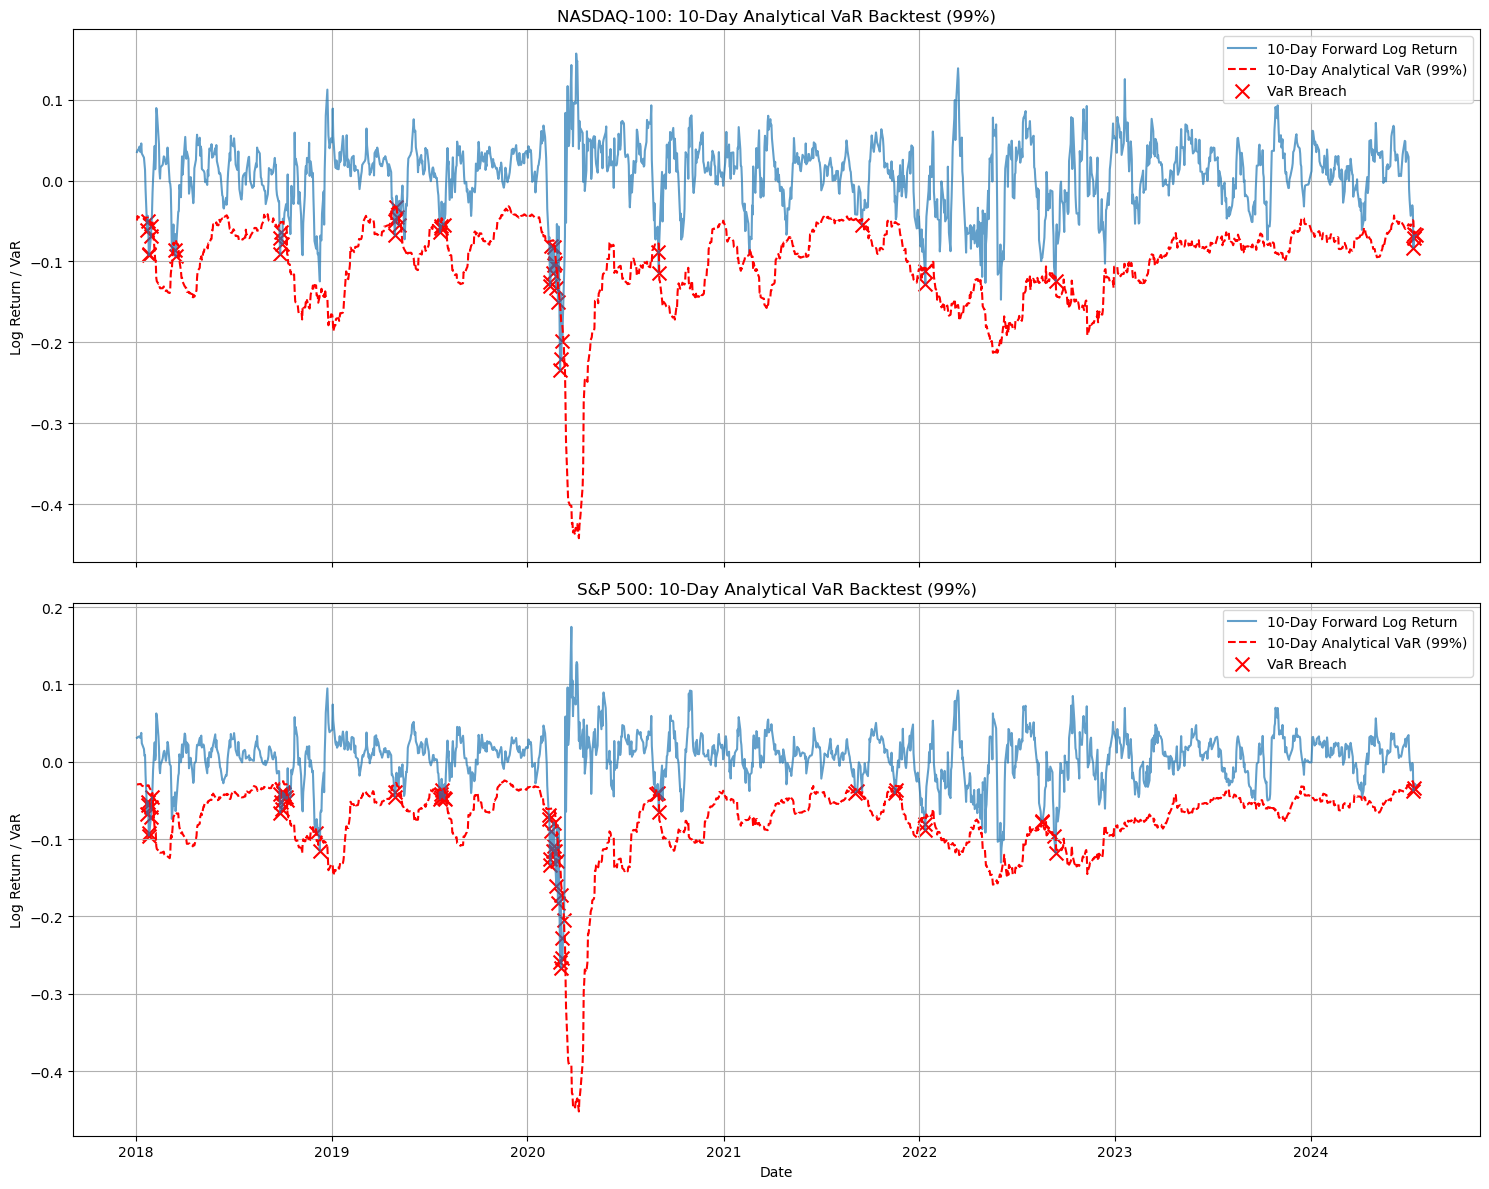

In [21]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot NASDAQ-100 backtest
ax1.plot(nasdaq_data_processed.index, nasdaq_data_processed['Forward_10D_LogReturn'], label='10-Day Forward Log Return', alpha=0.7)
ax1.plot(nasdaq_data_processed.index, nasdaq_data_processed['VaR_10D'], label='10-Day Analytical VaR (99%)', color='red', linestyle='--')
ax1.scatter(nasdaq_breaches.index, nasdaq_breaches['Forward_10D_LogReturn'], color='red', marker='x', s=100, label='VaR Breach')
ax1.set_title('NASDAQ-100: 10-Day Analytical VaR Backtest (99%)')
ax1.set_ylabel('Log Return / VaR')
ax1.legend()
ax1.grid(True)

# Plot S&P 500 backtest
ax2.plot(sp500_data_processed.index, sp500_data_processed['Forward_10D_LogReturn'], label='10-Day Forward Log Return', alpha=0.7)
ax2.plot(sp500_data_processed.index, sp500_data_processed['VaR_10D'], label='10-Day Analytical VaR (99%)', color='red', linestyle='--')
ax2.scatter(sp500_breaches.index, sp500_breaches['Forward_10D_LogReturn'], color='red', marker='x', s=100, label='VaR Breach')
ax2.set_title('S&P 500: 10-Day Analytical VaR Backtest (99%)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Log Return / VaR')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# 3(c) Listing VaR Breaches

## Implementation Process

### Step 1: Data Structuring
- Creates a structured DataFrame containing all VaR breach events

### Step 2: Data Inclusion
- Includes contextual information for each breach:
  - Date
  - Closing Price
  - LogReturn
  - VaR 10D
  - Ret 10D


In [ ]:
# NASDAQ-100 breach list
nasdaq_breach_report = nasdaq_breaches.reset_index()[['Date', 'Closing Price', 'Forward_10D_LogReturn', 'VaR_10D']]
nasdaq_breach_report.rename(columns={
    'Forward_10D_LogReturn': 'LogReturn',
    'VaR_10D': 'VaR 10D'
}, inplace=True)
nasdaq_breach_report['Ret 10D'] = nasdaq_breach_report['LogReturn'].apply(lambda x: f"{np.exp(x)-1:.2%}")

# S&P 500 breach list
sp500_breach_report = sp500_breaches.reset_index()[['Date', 'Closing Price', 'Forward_10D_LogReturn', 'VaR_10D']]
sp500_breach_report.rename(columns={
    'Forward_10D_LogReturn': 'LogReturn',
    'VaR_10D': 'VaR 10D'
}, inplace=True)
sp500_breach_report['Ret 10D'] = sp500_breach_report['LogReturn'].apply(lambda x: f"{np.exp(x)-1:.2%}")

#Implement the Display function to make result more clear on report
def display_breach_table(breach_report, title):
    # Create a copy to avoid modifying original
    display_df = breach_report.copy()
    
    # Format columns
    display_df['Date'] = display_df['Date'].dt.strftime('%Y-%m-%d')
    display_df['Closing Price'] = display_df['Closing Price'].apply(lambda x: f"${x:,.2f}")
    display_df['VaR 10D'] = display_df['VaR 10D'].apply(lambda x: f"{x:.4f}")
    display_df['LogReturn'] = display_df['LogReturn'].apply(lambda x: f"{x:.4f}")
    
    # Style the table
    styled_table = (
        display_df.style
        .set_caption(f"<b>{title} - {len(display_df)} Breach Events</b>")
        .set_properties(**{
            'text-align': 'center',
            'font-size': '12px',
            'border': '1px solid #ddd'
        })
        .set_table_styles([{
            'selector': 'th',
            'props': [
                ('background-color', '#f7f7f7'),
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('border', '1px solid #ddd')
            ]
        }, {
            'selector': 'td',
            'props': [('border', '1px solid #ddd')]
        }, {
            'selector': 'caption',
            'props': [
                ('font-size', '14px'),
                ('margin-bottom', '10px'),
                ('color', '#333')
            ]
        }])
        .format(precision=4)
    )
    
    # Display the table
    display(styled_table)

print("\nList of VaR Breaches:")
display_breach_table(nasdaq_breach_report, "NASDAQ-100 VaR Breaches")
display_breach_table(sp500_breach_report, "S&P 500 VaR Breaches")


List of VaR Breaches:


,Date,Closing Price,LogReturn,VaR 10D,Ret 10D
0,2018-01-22,"$6,906.28",-0.0613,-0.0458,-5.94%
1,2018-01-24,"$6,919.35",-0.0500,-0.0483,-4.88%
2,2018-01-25,"$6,916.30",-0.0924,-0.0482,-8.82%
3,2018-01-26,"$7,022.97",-0.0909,-0.0498,-8.69%
4,2018-01-29,"$6,988.32",-0.0688,-0.0516,-6.65%
5,2018-01-30,"$6,930.73",-0.0559,-0.0551,-5.44%
6,2018-03-14,"$7,040.98",-0.0860,-0.0771,-8.24%
7,2018-03-16,"$7,019.95",-0.0939,-0.0736,-8.96%
8,2018-09-26,"$7,563.09",-0.0710,-0.0530,-6.86%
9,2018-09-27,"$7,629.57",-0.0913,-0.0548,-8.72%


,Date,Closing Price,LogReturn,VaR 10D,Ret 10D
0,2018-01-22,"$2,832.97",-0.0672,-0.0310,-6.50%
1,2018-01-23,"$2,839.13",-0.0520,-0.0304,-5.07%
2,2018-01-24,"$2,837.54",-0.0565,-0.0309,-5.49%
3,2018-01-25,"$2,839.25",-0.0954,-0.0306,-9.10%
4,2018-01-26,"$2,872.87",-0.0923,-0.0332,-8.82%
5,2018-01-29,"$2,853.53",-0.0717,-0.0368,-6.92%
6,2018-01-30,"$2,822.43",-0.0582,-0.0430,-5.65%
7,2018-01-31,"$2,823.81",-0.0453,-0.0412,-4.43%
8,2018-09-26,"$2,905.97",-0.0423,-0.0272,-4.14%
9,2018-09-27,"$2,914.00",-0.0658,-0.0275,-6.37%


## 3(d) Comparative Risk Analysis

During the initial COVID-19 pandemic period (February to March 2020), the NASDAQ-100 was indeed riskier than the S&P 500. The NASDAQ-100 experienced significantly higher volatility, as evidenced by its Value-at-Risk (VaR) line becoming much steeper (more negative). This resulted in larger magnitude losses, with the realized 10-day log returns showing deeper negative movements. While both indices had VaR breaches, the NASDAQ-100's realized losses during these events were more extreme, indicating its downside risk exceeded the 99% VaR forecast more dramatically. This behavior is consistent with its composition of technology and growth stocks, which are more sensitive to sudden, macroeconomic shocks.

The NASDAQ-100 also proved to be more risky than the S&P 500 during the market correction period from 2021 to 2022. As the Federal Reserve began to raise interest rates, the NASDAQ-100's volatility was sustained at a significantly higher level. The plots from this period show a more volatile and steep downward trend for the NASDAQ-100, whereas the S&P 500’s correction was more gradual. Furthermore, the NASDAQ-100's backtest results revealed a higher number of VaR breaches, which were concentrated in late 2021 and 2022. This suggests that the index’s downside risk was increasing more rapidly and consistently, a typical sign of growth stocks being repriced in a higher-rate environment, confirming its greater sensitivity to economic shifts.